# Reinforcement Learning 2025 - Midterm Assignment

**Authors:** Gal Yaacov Noy, Amit Ezer.

**Goal:** Implement and compare SARSA and Double Q-Learning agents in a dynamic obstacle environment.  

In [183]:
!pip install minigrid gymnasium matplotlib

In [184]:
import os
import numpy as np
import gymnasium as gym
import minigrid
import matplotlib.pyplot as plt
import pickle

np.random.seed(42)

In [185]:
def get_discrete_state(env):
    """
    Discretize the state: (flat_position, direction, is_blocked).
    `env` must be the unwrapped MiniGrid environment.
    """
    x = (env.agent_pos[0] - 1) * (env.width - 2) + (env.agent_pos[1] - 1)  # Flatten the position
    direction = env.agent_dir

    # Check if the front cell is blocked
    front_cell = env.grid.get(*env.front_pos)
    if front_cell is None:
        blocked = 0
    else:
        blocked = int(front_cell.type != "goal")

    return (x, direction, blocked)

def init_q_table(random_init, state_shape, num_actions):
    """Initialize Q-table with zeros or small random values."""
    if random_init:
        return np.random.uniform(-0.05, 0.05, (*state_shape, num_actions))
    return np.zeros((*state_shape, num_actions))

def get_shaped_reward(obs, reward, use_shaping):
    """Shape reward: bonus for facing goal (ID 8), penalty for obstacle."""
    if not use_shaping:
        return reward

    img = obs["image"][:, :, 0]
    center = np.array(img.shape) // 2
    dx, dy = {
        0: (-1, 0),   # Up
        1: (0, 1),    # Right
        2: (1, 0),    # Down
        3: (0, -1),   # Left
    }[obs["direction"]]

    fx, fy = center[0] + dx, center[1] + dy
    if not (0 <= fx < img.shape[0] and 0 <= fy < img.shape[1]):
        return reward  # Facing out of bounds

    tile = img[fx, fy]
    if tile == 8:
        return reward + 0.2  # Facing goal
    elif tile != 0:
        return reward - 0.1  # Facing obstacle

    return reward

def epsilon_greedy(q_values, epsilon, num_actions):
    """Epsilon-greedy action selection."""
    if np.random.rand() < epsilon:
        return np.random.randint(num_actions)
    return int(np.argmax(q_values))

def log_episode(logs, reward, steps, success):
    """Store training statistics for later analysis."""
    logs["rewards"].append(reward)
    logs["steps"].append(steps)
    logs["successes"].append(int(success))

In [186]:
def train_agent(
    env,
    agent_name="SARSA",
    num_episodes=1000,
    alpha=0.1,
    gamma=0.99,
    epsilon_start=1.0,
    epsilon_min=0.05,
    epsilon_decay=0.995,
    random_q_init=False,
    use_reward_shaping=False,
):
    """
    Train agent using SARSA or Double Q-learning with a discrete state space.
    """
    # Access unwrapped MiniGrid env for agent_pos, width, etc.
    base_env = env.unwrapped

    # Discretized state shape: (x_pos, direction, obstacle_ahead)
    num_positions = (base_env.width - 2) * (base_env.height - 2)
    state_shape = (num_positions, 4, 2)
    num_actions = env.action_space.n

    q1 = init_q_table(random_q_init, state_shape, num_actions)
    q2 = init_q_table(random_q_init, state_shape, num_actions) if agent_name == "Double Q-Learning" else None

    logs = {"rewards": [], "steps": [], "successes": []}
    epsilon = epsilon_start

    for episode in range(num_episodes):
        env.reset()
        x, d, b = get_discrete_state(base_env)
        q_values = q1[x, d, b] if q2 is None else q1[x, d, b] + q2[x, d, b]
        action = epsilon_greedy(q_values, epsilon, num_actions)

        total_reward, steps = 0, 0
        terminated = truncated = False

        while not (terminated or truncated):
            next_obs, base_reward, terminated, truncated, _ = env.step(action)
            shaped_reward = get_shaped_reward(next_obs, base_reward, use_reward_shaping)

            next_x, next_d, next_b = get_discrete_state(base_env)
            done = terminated or truncated
            total_reward += shaped_reward
            steps += 1

            if agent_name == "SARSA":
                next_action = epsilon_greedy(q1[next_x, next_d, next_b], epsilon, num_actions)
                td_target = shaped_reward + gamma * q1[next_x, next_d, next_b, next_action] * (not done)
                td_error = td_target - q1[x, d, b, action]
                q1[x, d, b, action] += alpha * td_error
                action = next_action

            elif agent_name == "Double Q-Learning":
                use_q1 = np.random.rand() < 0.5
                q_main, q_other = (q1, q2) if use_q1 else (q2, q1)

                a_max = np.argmax(q_main[next_x, next_d, next_b])
                td_target = shaped_reward + gamma * q_other[next_x, next_d, next_b, a_max] * (not done)
                td_error = td_target - q_main[x, d, b, action]
                q_main[x, d, b, action] += alpha * td_error

                action = epsilon_greedy(q1[next_x, next_d, next_b] + q2[next_x, next_d, next_b], epsilon, num_actions)

            x, d, b = next_x, next_d, next_b

        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        # Success is reaching the goal (positive shaped reward) and episode terminated normally
        log_episode(logs, total_reward, steps, shaped_reward > 0 and terminated)

        if episode % 100 == 0:
            print(f"[{agent_name}] Ep {episode} - reward: {total_reward:.2f}, steps: {steps}, success: {shaped_reward > 0 and terminated}")

    return q1, q2, logs

In [187]:
def plot_results(sarsa_logs, dq_logs, window=100, title="Training Results"):
    """Plot training results."""
    def moving_average(data, window):
        return np.convolve(data, np.ones(window)/window, mode='valid')

    _, axs = plt.subplots(1, 3, figsize=(15, 4), sharex=False)
    plt.suptitle(title, fontsize=16)

    metrics = [
        ("rewards", "Average Reward", "Reward"),
        ("steps", "Episode Length", "Steps"),
        ("successes", "Success Rate", "Success Rate")
    ]

    for i, (metric, title_text, ylabel) in enumerate(metrics):
        axs[i].plot(moving_average(sarsa_logs[metric], window), label="SARSA", linewidth=2)
        axs[i].plot(moving_average(dq_logs[metric], window), label="Double Q-Learning", linewidth=2)
        axs[i].set_title(title_text)
        axs[i].set_ylabel(ylabel)
        axs[i].legend()
        axs[i].grid(alpha=0.3)
        if i == 1:  # Middle plot gets x-label
            axs[i].set_xlabel("Episode")

    plt.tight_layout()
    plt.show()

def print_performance_summary(sarsa_logs, dq_logs, mode_name):
    """Print performance summary for the current mode."""
    print(f"\n{'='*60}")
    print(f"PERFORMANCE SUMMARY - {mode_name.upper()}")
    print(f"{'='*60}")
    
    # Calculate metrics for both algorithms
    def get_metrics(logs):
        final_success = np.mean(logs["successes"][-100:]) * 100
        best_success = max([np.mean(logs["successes"][i:i+100]) * 100 
                           for i in range(len(logs["successes"])-99)])
        final_reward = np.mean(logs["rewards"][-100:])
        final_steps = np.mean(logs["steps"][-100:])
        return final_success, best_success, final_reward, final_steps
    
    sarsa_metrics = get_metrics(sarsa_logs)
    dq_metrics = get_metrics(dq_logs)
    
    # Print results
    for name, metrics in [("SARSA", sarsa_metrics), ("Double Q-Learning", dq_metrics)]:
        final_success, best_success, final_reward, final_steps = metrics
        print(f"{name} Results:")
        print(f"  Final Success Rate: {final_success:.1f}% | Best: {best_success:.1f}%")
        print(f"  Final Reward: {final_reward:.3f} | Final Steps: {final_steps:.1f}")
    
    # Winner determination
    winner = "SARSA" if sarsa_metrics[0] > dq_metrics[0] else "Double Q-Learning"
    margin = abs(sarsa_metrics[0] - dq_metrics[0])
    print(f"\nWinner: {winner} (by {margin:.1f}%)")
    print(f"{'='*60}")

def save_policies(sarsa_q, double_q1, double_q2, mode="baseline"):
    """
    Save Q-tables into a subfolder under 'policies/' named after the mode.
    For example: policies/baseline/sarsa_q.pkl
    """
    print(f"\nSaving Q-tables for mode: {mode}")
    
    folder = os.path.join("policies", mode)
    os.makedirs(folder, exist_ok=True)

    policies = {
        "sarsa_q": sarsa_q,
        "double_q1": double_q1,
        "double_q2": double_q2
    }

    for name, q_table in policies.items():
        if q_table is not None:  # Skip None Q-tables (e.g., q2 for SARSA)
            path = os.path.join(folder, f"{name}.pkl")
            with open(path, 'wb') as f:
                pickle.dump(q_table, f)
            
    print(f"Q-tables saved to: {folder}")

def run_experiment(env, config_name, **kwargs):
    """Run complete experiment: train both agents, analyze, plot, and save."""
    print(f"\n{'='*60}")
    print(f"RUNNING EXPERIMENT: {config_name.upper()}")
    print(f"{'='*60}")
    
    # Train both agents
    print("Training SARSA...")
    sarsa_q, _, sarsa_logs = train_agent(env, "SARSA", **kwargs)
    
    print("Training Double Q-Learning...")
    dq_q1, dq_q2, dq_logs = train_agent(env, "Double Q-Learning", **kwargs)
    
    # Analyze and visualize
    print_performance_summary(sarsa_logs, dq_logs, config_name)
    plot_results(sarsa_logs, dq_logs, title=config_name)
    
    # Save policies
    mode = config_name.lower().replace(" ", "_").replace("-", "_")
    save_policies(sarsa_q, dq_q1, dq_q2, mode)
    
    return sarsa_logs, dq_logs


RUNNING EXPERIMENT: BASELINE
Training SARSA...
[SARSA] Ep 0 - reward: -1.00, steps: 4, success: False
[SARSA] Ep 100 - reward: -1.00, steps: 3, success: False
[SARSA] Ep 200 - reward: -1.00, steps: 17, success: False
[SARSA] Ep 300 - reward: 0.90, steps: 16, success: True
[SARSA] Ep 400 - reward: -1.00, steps: 44, success: False
[SARSA] Ep 500 - reward: -1.00, steps: 4, success: False
[SARSA] Ep 600 - reward: 0.85, steps: 24, success: True
[SARSA] Ep 700 - reward: 0.93, steps: 12, success: True
[SARSA] Ep 800 - reward: 0.92, steps: 13, success: True
[SARSA] Ep 900 - reward: 0.83, steps: 27, success: True
Training Double Q-Learning...
[Double Q-Learning] Ep 0 - reward: -1.00, steps: 4, success: False
[Double Q-Learning] Ep 100 - reward: -1.00, steps: 16, success: False
[Double Q-Learning] Ep 200 - reward: -1.00, steps: 8, success: False
[Double Q-Learning] Ep 300 - reward: -1.00, steps: 28, success: False
[Double Q-Learning] Ep 400 - reward: -1.00, steps: 15, success: False
[Double Q-L

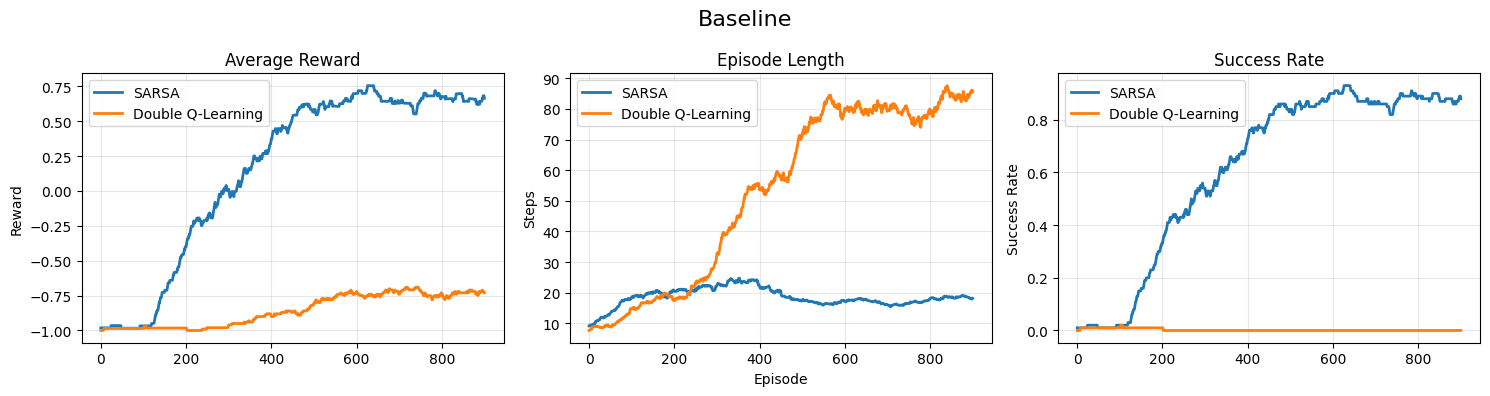


Saving Q-tables for mode: baseline
Q-tables saved to: policies/baseline

RUNNING EXPERIMENT: RANDOM Q-INIT
Training SARSA...
[SARSA] Ep 0 - reward: -1.00, steps: 1, success: False
[SARSA] Ep 100 - reward: -1.00, steps: 6, success: False
[SARSA] Ep 200 - reward: -1.00, steps: 10, success: False
[SARSA] Ep 300 - reward: 0.68, steps: 52, success: True
[SARSA] Ep 400 - reward: -1.00, steps: 36, success: False
[SARSA] Ep 500 - reward: 0.89, steps: 18, success: True
[SARSA] Ep 600 - reward: 0.81, steps: 31, success: True
[SARSA] Ep 700 - reward: 0.86, steps: 22, success: True
[SARSA] Ep 800 - reward: 0.83, steps: 27, success: True
[SARSA] Ep 900 - reward: 0.89, steps: 18, success: True
Training Double Q-Learning...
[Double Q-Learning] Ep 0 - reward: -1.00, steps: 2, success: False
[Double Q-Learning] Ep 100 - reward: -1.00, steps: 7, success: False
[Double Q-Learning] Ep 200 - reward: -1.00, steps: 13, success: False
[Double Q-Learning] Ep 300 - reward: -1.00, steps: 53, success: False
[Dou

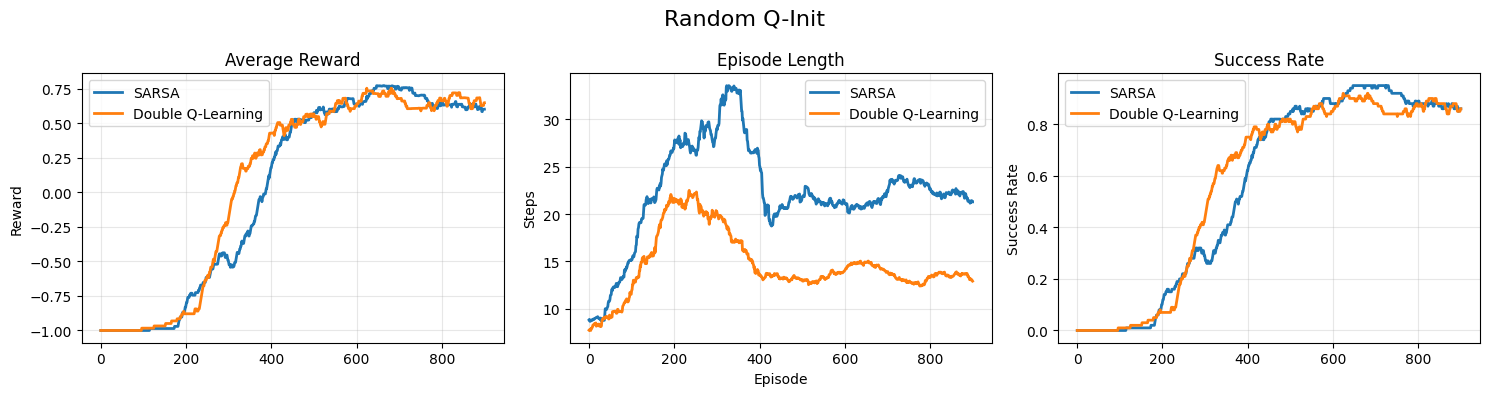


Saving Q-tables for mode: random_q_init
Q-tables saved to: policies/random_q_init

RUNNING EXPERIMENT: RANDOM Q-INIT + REWARD SHAPING
Training SARSA...
[SARSA] Ep 0 - reward: -1.10, steps: 1, success: False
[SARSA] Ep 100 - reward: -1.60, steps: 6, success: False
[SARSA] Ep 200 - reward: -2.10, steps: 11, success: False
[SARSA] Ep 300 - reward: -4.20, steps: 32, success: False
[SARSA] Ep 400 - reward: 0.24, steps: 10, success: True
[SARSA] Ep 500 - reward: -0.29, steps: 15, success: True
[SARSA] Ep 600 - reward: -0.40, steps: 16, success: True
[SARSA] Ep 700 - reward: -0.06, steps: 10, success: True
[SARSA] Ep 800 - reward: 0.71, steps: 14, success: True
[SARSA] Ep 900 - reward: 0.34, steps: 9, success: True
Training Double Q-Learning...
[Double Q-Learning] Ep 0 - reward: -1.80, steps: 8, success: False
[Double Q-Learning] Ep 100 - reward: -1.80, steps: 8, success: False
[Double Q-Learning] Ep 200 - reward: -4.00, steps: 30, success: False
[Double Q-Learning] Ep 300 - reward: -2.00, s

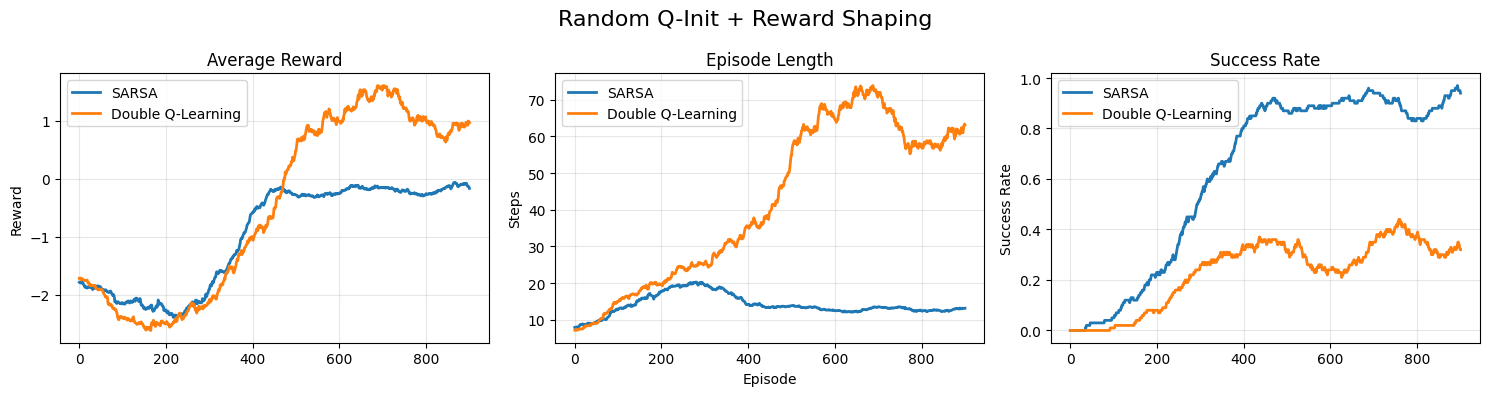


Saving Q-tables for mode: random_q_init_+_reward_shaping
Q-tables saved to: policies/random_q_init_+_reward_shaping

ALL EXPERIMENTS COMPLETED!


In [188]:
# Run all experiments
env = gym.make("MiniGrid-Dynamic-Obstacles-6x6-v0")

# Experiment configurations
experiments = [
    ("Baseline", {}),
    ("Random Q-Init", {"random_q_init": True}),
    ("Random Q-Init + Reward Shaping", {"random_q_init": True, "use_reward_shaping": True})
]

# Store results for comparison
all_results = {}
for config_name, config_params in experiments:
    sarsa_logs, dq_logs = run_experiment(env, config_name, **config_params)
    all_results[config_name] = {"sarsa": sarsa_logs, "dq": dq_logs}

print("\n" + "="*80)
print("ALL EXPERIMENTS COMPLETED!")
print("="*80)

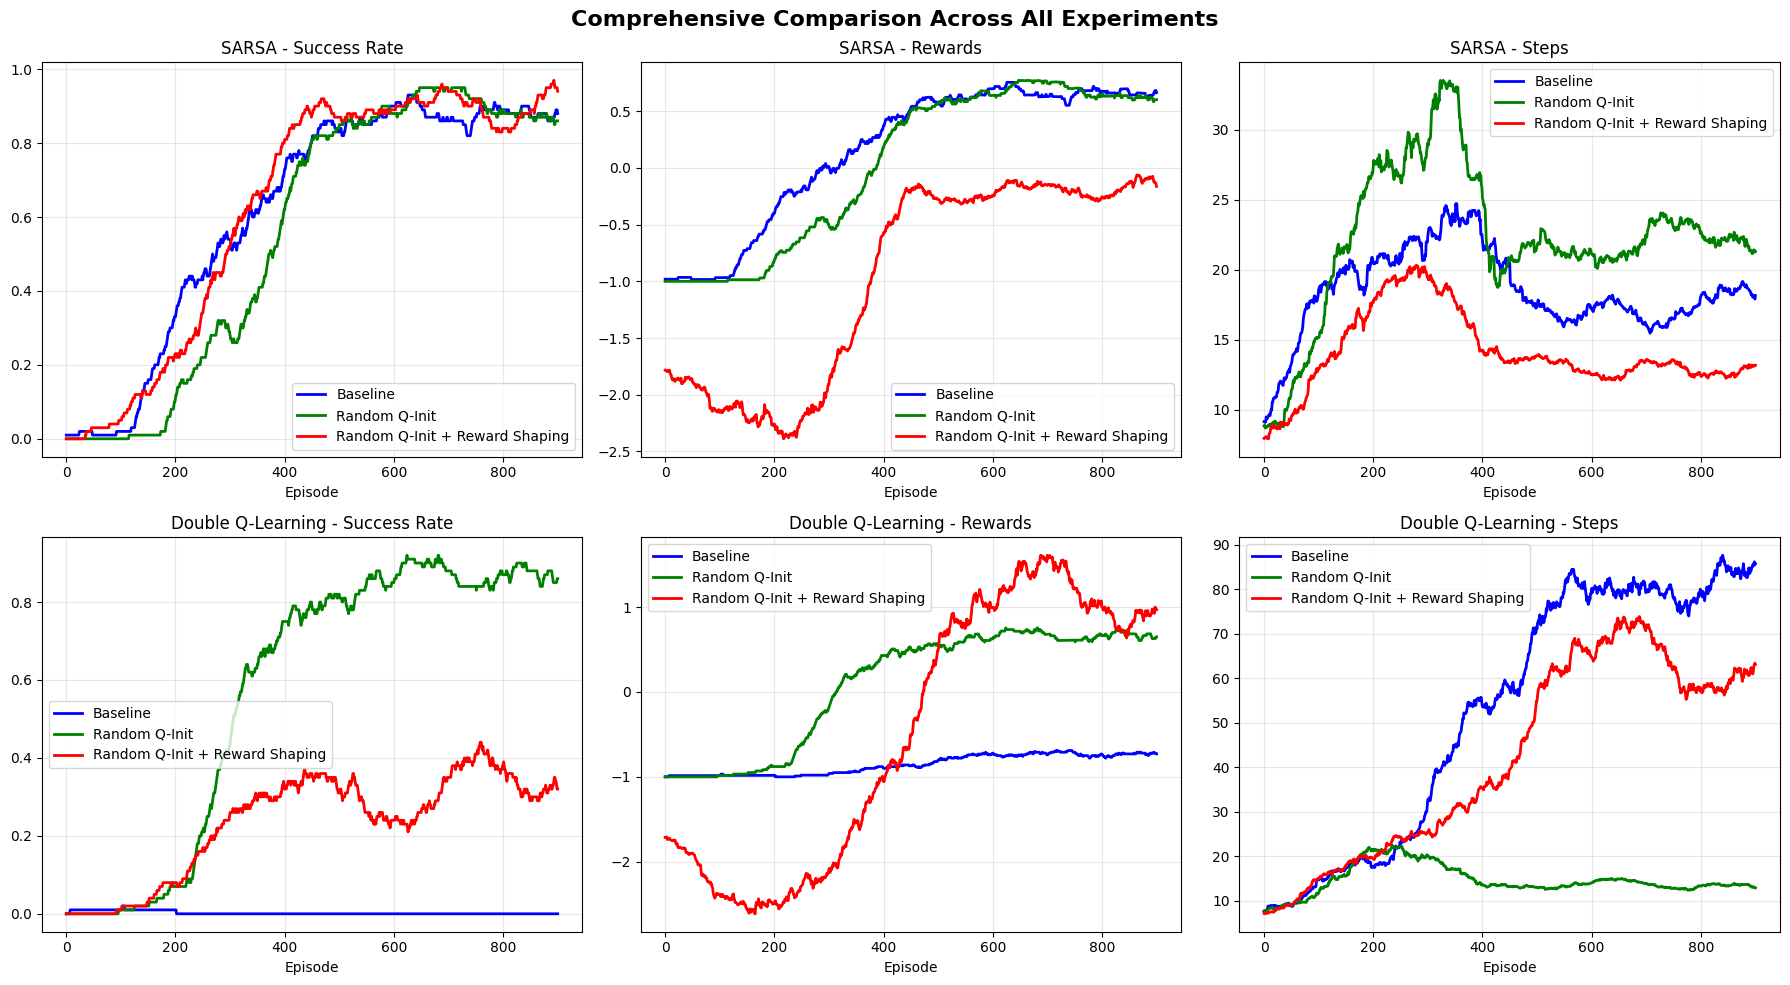


FINAL PERFORMANCE COMPARISON TABLE
Configuration                   Algorithm           Final Success %  Best Success %   Final Reward     Final Steps  
--------------------------------------------------------------------------------------------------------------------
Baseline                         SARSA                88.0              93.0              0.665             18.1         
Baseline                         Double Q-Learning    0.0               2.0               -0.730            85.7         
Random Q-Init                    SARSA                86.0              95.0              0.602             21.3         
Random Q-Init                    Double Q-Learning    86.0              92.0              0.649             12.9         
Random Q-Init + Reward Shaping   SARSA                94.0              97.0              -0.163            13.2         
Random Q-Init + Reward Shaping   Double Q-Learning    32.0              44.0              0.969             63.1        

In [189]:
# Final Comprehensive Analysis
def plot_all_experiments_comparison(all_results):
    """Plot comparison across all experiment configurations."""
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle("Comprehensive Comparison Across All Experiments", fontsize=16, fontweight='bold')
    
    def moving_average(data, window=100):
        return np.convolve(data, np.ones(window)/window, mode='valid')
    
    colors = ['blue', 'green', 'red', 'orange']
    
    # Plot SARSA results
    for i, (config, color) in enumerate(zip(all_results.keys(), colors)):
        sarsa_logs = all_results[config]["sarsa"]
        
        # Success rate
        axes[0, 0].plot(moving_average(sarsa_logs["successes"]), 
                       label=config, color=color, linewidth=2)
        # Rewards
        axes[0, 1].plot(moving_average(sarsa_logs["rewards"]), 
                       label=config, color=color, linewidth=2)
        # Steps
        axes[0, 2].plot(moving_average(sarsa_logs["steps"]), 
                       label=config, color=color, linewidth=2)
    
    # Plot Double Q-Learning results
    for i, (config, color) in enumerate(zip(all_results.keys(), colors)):
        dq_logs = all_results[config]["dq"]
        
        # Success rate
        axes[1, 0].plot(moving_average(dq_logs["successes"]), 
                       label=config, color=color, linewidth=2)
        # Rewards
        axes[1, 1].plot(moving_average(dq_logs["rewards"]), 
                       label=config, color=color, linewidth=2)
        # Steps
        axes[1, 2].plot(moving_average(dq_logs["steps"]), 
                       label=config, color=color, linewidth=2)
    
    # Configure subplots
    titles = [["SARSA - Success Rate", "SARSA - Rewards", "SARSA - Steps"],
              ["Double Q-Learning - Success Rate", "Double Q-Learning - Rewards", "Double Q-Learning - Steps"]]
    
    for i in range(2):
        for j in range(3):
            axes[i, j].set_title(titles[i][j])
            axes[i, j].legend()
            axes[i, j].grid(alpha=0.3)
            axes[i, j].set_xlabel("Episode")
    
    plt.tight_layout()
    plt.show()
    
def final_performance_table(all_results):
    """Print a clean, left-aligned performance summary table."""
    headers = ["Configuration", "Algorithm", "Final Success %", "Best Success %", "Final Reward", "Final Steps"]
    col_widths = [32, 20, 17, 17, 17, 13]
    total_width = sum(col_widths)

    # Format headers (all left-aligned)
    header_fmt = "".join([f"{{:<{w}}}" for w in col_widths])
    row_fmt = (
        f"{{:<{col_widths[0]}}} "  # Configuration
        f"{{:<{col_widths[1]}}} "  # Algorithm
        f"{{:<{col_widths[2]}.1f}} "  # Final Success %
        f"{{:<{col_widths[3]}.1f}} "  # Best Success %
        f"{{:<{col_widths[4]}.3f}} "  # Final Reward
        f"{{:<{col_widths[5]}.1f}}"   # Final Steps
    )

    print("\n" + "=" * total_width)
    print("FINAL PERFORMANCE COMPARISON TABLE")
    print("=" * total_width)
    print(header_fmt.format(*headers))
    print("-" * total_width)

    best_configs = {}

    for config_name, results in all_results.items():
        for alg_name, alg_key in [("SARSA", "sarsa"), ("Double Q-Learning", "dq")]:
            logs = results[alg_key]
            final_success = np.mean(logs["successes"][-100:]) * 100
            best_success = max([
                np.mean(logs["successes"][i:i+100]) * 100
                for i in range(len(logs["successes"]) - 99)
            ])
            final_reward = np.mean(logs["rewards"][-100:])
            final_steps = np.mean(logs["steps"][-100:])

            print(row_fmt.format(
                config_name, alg_name, final_success, best_success, final_reward, final_steps
            ))

            best_configs[f"{config_name} + {alg_name}"] = final_success

    best_config = max(best_configs, key=best_configs.get)
    best_score = best_configs[best_config]

    print("-" * total_width)
    print(f"OVERALL BEST CONFIGURATION: {best_config} with {best_score:.1f}% success rate")
    print("=" * total_width)


# Run final analysis
plot_all_experiments_comparison(all_results)
final_performance_table(all_results)

# Save all results for future analysis
with open("experiment_results.pkl", "wb") as f:
    pickle.dump(all_results, f)

print("\nAll experiment results saved to 'experiment_results.pkl'")
print("Q-tables saved in 'policies/' directory")
print("\nExperiment complete!")

In [190]:
env = gym.make("MiniGrid-Dynamic-Obstacles-8x8-v0")

# Train SARSA and Double Q-Learning on the 8x8 environment
sarsa_logs, dq_logs = run_experiment(env, "8x8 Dynamic Obstacles", num_episodes=3000, alpha=0.05, epsilon_decay=0.998, random_q_init=True, use_reward_shaping=True)


RUNNING EXPERIMENT: 8X8 DYNAMIC OBSTACLES
Training SARSA...
[SARSA] Ep 0 - reward: -1.10, steps: 1, success: False
[SARSA] Ep 100 - reward: -2.60, steps: 16, success: False
[SARSA] Ep 200 - reward: -1.30, steps: 3, success: False
[SARSA] Ep 300 - reward: -1.60, steps: 6, success: False
[SARSA] Ep 400 - reward: -3.50, steps: 25, success: False
[SARSA] Ep 500 - reward: -4.40, steps: 34, success: False
[SARSA] Ep 600 - reward: -5.01, steps: 61, success: True
[SARSA] Ep 700 - reward: -2.80, steps: 18, success: False
[SARSA] Ep 800 - reward: -0.77, steps: 20, success: True
[SARSA] Ep 900 - reward: -4.30, steps: 33, success: False
[SARSA] Ep 1000 - reward: -0.25, steps: 15, success: True
[SARSA] Ep 1100 - reward: -3.60, steps: 26, success: False
[SARSA] Ep 1200 - reward: -1.60, steps: 6, success: False
[SARSA] Ep 1300 - reward: 0.16, steps: 11, success: True
[SARSA] Ep 1400 - reward: -0.67, steps: 19, success: True
[SARSA] Ep 1500 - reward: -0.77, steps: 20, success: True
[SARSA] Ep 1600 - 

KeyboardInterrupt: 

In [ ]:
# Evaluation: Test saved Q-tables
def evaluate_trained_agents(env_name, q_tables_path, num_eval_episodes=100, use_reward_shaping=False):
    """Evaluate trained agents using saved Q-tables."""
    env = gym.make(env_name)
    base_env = env.unwrapped
    
    # Load saved Q-tables
    try:
        with open(f"{q_tables_path}/sarsa_q.pkl", 'rb') as f:
            sarsa_q = pickle.load(f)
        with open(f"{q_tables_path}/double_q1.pkl", 'rb') as f:
            double_q1 = pickle.load(f)
        with open(f"{q_tables_path}/double_q2.pkl", 'rb') as f:
            double_q2 = pickle.load(f)
    except FileNotFoundError as e:
        print(f"Error loading policy files: {e}")
        print("Please ensure that training has been run and policies are saved in the correct directory.")
        return

    results = {}
    
    for agent_name in ["SARSA", "Double Q-Learning"]:
        successes = 0
        total_rewards = 0
        total_steps = 0
        
        for episode in range(num_eval_episodes):
            obs, _ = env.reset()
            done = False
            episode_reward = 0
            episode_steps = 0
            
            while not done:
                x, d, b = get_discrete_state(base_env)
                
                if agent_name == "SARSA":
                    action = np.argmax(sarsa_q[x, d, b])
                else:  # Double Q-Learning
                    action = np.argmax(double_q1[x, d, b] + double_q2[x, d, b])
                
                obs, base_reward, terminated, truncated, _ = env.step(action)
                shaped_reward = get_shaped_reward(obs, base_reward, use_reward_shaping)
                
                done = terminated or truncated
                episode_reward += shaped_reward
                episode_steps += 1
            
            if shaped_reward > 0 and terminated:
                successes += 1
            total_rewards += episode_reward
            total_steps += episode_steps
        
        success_rate = (successes / num_eval_episodes) * 100
        avg_reward = total_rewards / num_eval_episodes
        avg_steps = total_steps / num_eval_episodes
        
        results[agent_name] = {
            "success_rate": success_rate,
            "avg_reward": avg_reward,
            "avg_steps": avg_steps
        }
        
        print(f"--- {agent_name} Evaluation Results ---")
        print(f"  Success Rate: {success_rate:.1f}%")
        print(f"  Average Reward: {avg_reward:.3f}")
        print(f"  Average Steps: {avg_steps:.1f}")
        print()
    
    return results

# Evaluate the best configuration from the 6x6 experiments
print("="*60)
print("Evaluating Best 6x6 Configuration: Random Q-Init + Reward Shaping")
print("="*60)
evaluation_results = evaluate_trained_agents(
    "MiniGrid-Dynamic-Obstacles-6x6-v0", 
    "policies/random_q_init_+_reward_shaping",
    num_eval_episodes=100,
    use_reward_shaping=True  # This configuration used reward shaping
)

# Save evaluation results
with open("evaluation_results.pkl", "wb") as f:
    pickle.dump(evaluation_results, f)
print("\nEvaluation results saved to 'evaluation_results.pkl'")

Evaluating Best 6x6 Configuration: Random Q-Init + Reward Shaping
--- SARSA Evaluation Results ---
  Success Rate: 100.0%
  Average Reward: 0.028
  Average Steps: 12.6

--- Double Q-Learning Evaluation Results ---
  Success Rate: 100.0%
  Average Reward: -0.043
  Average Steps: 14.7


Evaluation results saved to 'evaluation_results.pkl'
